<a href="https://colab.research.google.com/github/318281029SBH/Escuela/blob/main/GWeatherLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif
from sklearn.metrics import r2_score, make_scorer
from sklearn.impute import SimpleImputer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Exploratory Analysis

In [ ]:
dwd=pd.read_csv('/content/drive/MyDrive/dataSet/DWD.csv', sep=',', index_col=0 )

In [ ]:
dwd.drop(['DWD_ID', 'STATION_NAME', 'FEDERAL_STATE', 'PERIOD'], axis=1,inplace=TRUE)
#dwd.loc[lambda dwd: dwd.isnull().any(axis=1)].shape

Columns wich have at least 30% of missings values are delate

In [ ]:
miss=dwd.describe().T[['count']]/len(dwd) #proportion betwen column data and total
areleft=miss.loc[miss['count']>.7]
dwd=dwd[[v for v in areleft.index]]

##Data Visualization

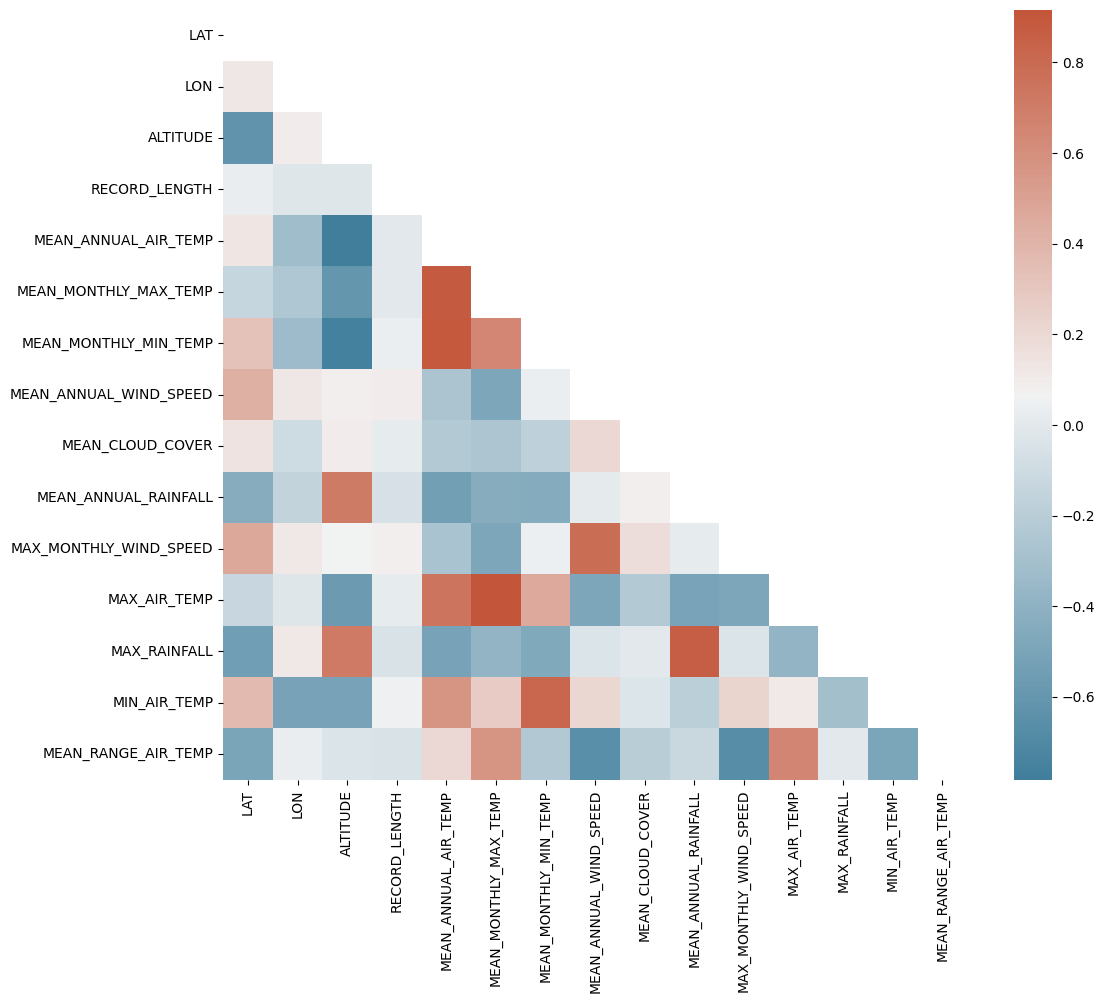

,MEAN_ANNUAL_RAINFALL
MEAN_ANNUAL_RAINFALL,1.000000
MAX_RAINFALL,0.863788
ALTITUDE,0.709002
MAX_AIR_TEMP,-0.509815
MEAN_ANNUAL_AIR_TEMP,-0.539133


In [ ]:
#Pearson Correlation
corr = dwd.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=cmap)
plt.show()

#best features
corr.loc[corr.abs()['MEAN_ANNUAL_RAINFALL']>.5].filter(like='MEAN_ANNUAL_RAINFALL', axis=1).sort_values(by='MEAN_ANNUAL_RAINFALL', ascending=False)


array([[<Axes: title={'center': 'LAT'}>, <Axes: title={'center': 'LON'}>,
        <Axes: title={'center': 'ALTITUDE'}>,
        <Axes: title={'center': 'RECORD_LENGTH'}>],
       [<Axes: title={'center': 'MEAN_ANNUAL_AIR_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MAX_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MIN_TEMP'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_WIND_SPEED'}>],
       [<Axes: title={'center': 'MEAN_CLOUD_COVER'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_RAINFALL'}>,
        <Axes: title={'center': 'MAX_MONTHLY_WIND_SPEED'}>,
        <Axes: title={'center': 'MAX_AIR_TEMP'}>],
       [<Axes: title={'center': 'MAX_RAINFALL'}>,
        <Axes: title={'center': 'MIN_AIR_TEMP'}>,
        <Axes: title={'center': 'MEAN_RANGE_AIR_TEMP'}>, <Axes: >]],
      dtype=object)

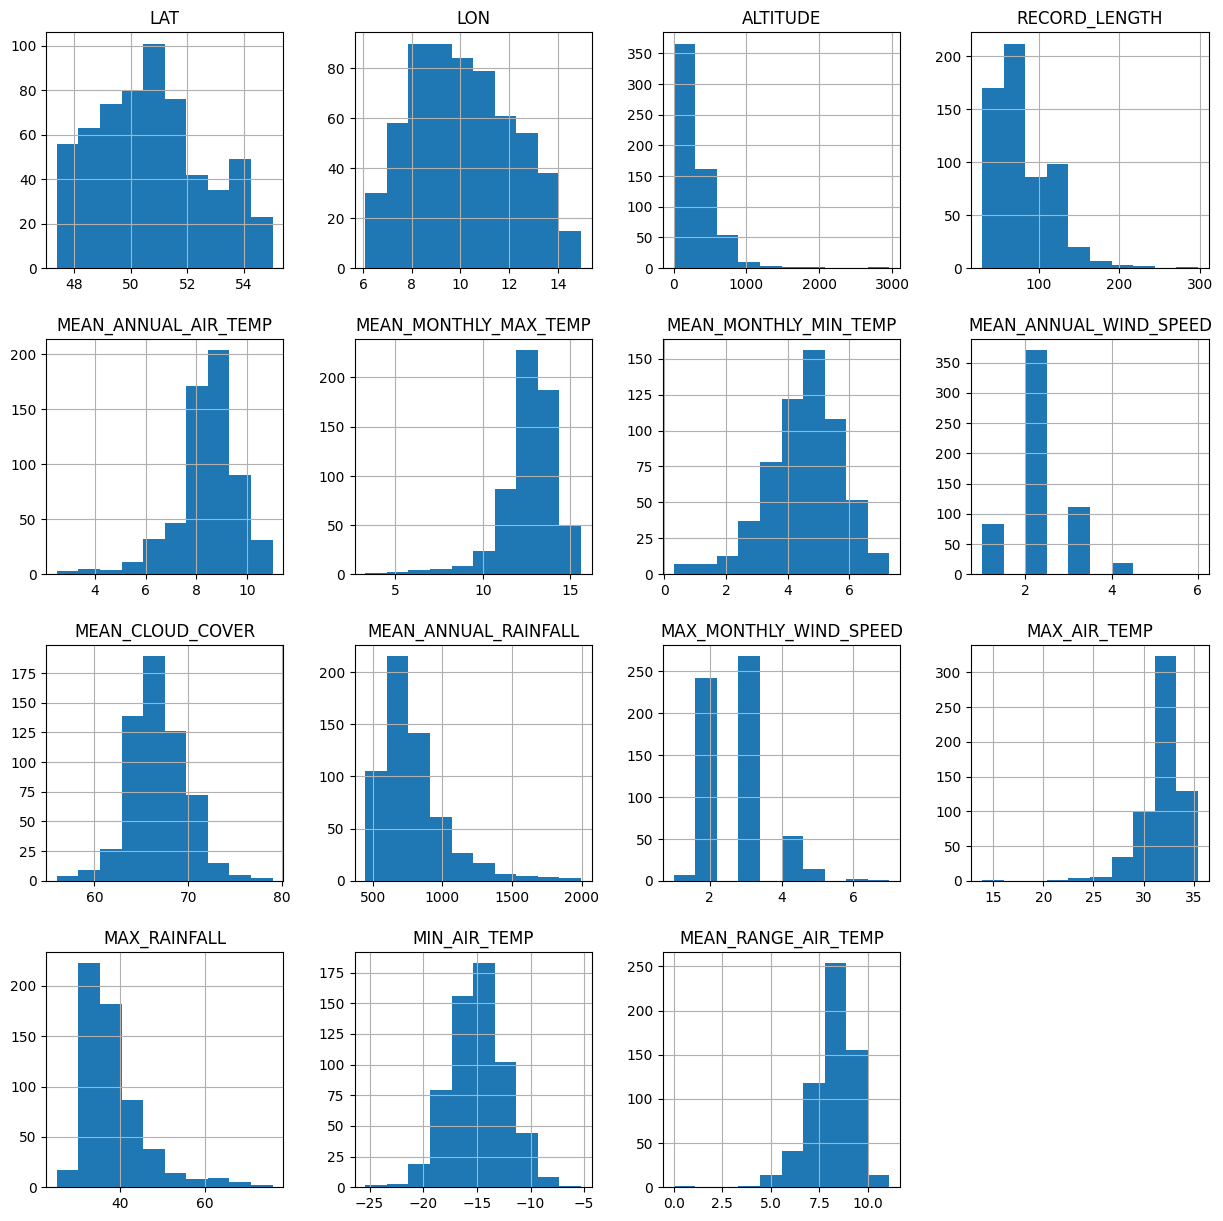

In [ ]:
dwd.hist(figsize=(15,15))

# Imputar, strategy:Median

In [ ]:
im = SimpleImputer(strategy='median')
im.fit(dwd)

SimpleImputer(strategy='median')

In [ ]:
Xi = pd.DataFrame(im.transform(dwd),columns=dwd.columns) #imputa valores vacíos con mediana
Xi.describe()

Kolmogorov-Smirnof test to verify no changes in data distribution

In [ ]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],dwd[v].dropna()).statistic),dwd.columns),columns=['var','ks']).sort_values('ks',ascending=False) #prueba Kolmogorov-Smirnof para determinar si mantiene la distribución
ks

In [ ]:
out = ks[ks['ks']>0.1]['var'].tolist() #variables que deben salir
var = [v for v in Xi.columns if v not in out] # variables que deben permanecer
Xi.drop(out,axis=1,inplace=True)

# OutLayers

In [ ]:
Xi.describe().T[['50%','75%']].reset_index().values

array([['LAT', 50.639, 51.9568],
       ['LON', 9.9662, 11.7028],
       ['ALTITUDE', 224.0, 418.0],
       ['RECORD_LENGTH', 70.0, 103.0],
       ['MEAN_ANNUAL_AIR_TEMP', 8.5, 9.1],
       ['MEAN_MONTHLY_MAX_TEMP', 12.9, 13.5],
       ['MEAN_MONTHLY_MIN_TEMP', 4.6, 5.3],
       ['MEAN_ANNUAL_WIND_SPEED', 2.0, 2.0],
       ['MEAN_CLOUD_COVER', 67.0, 68.0],
       ['MEAN_ANNUAL_RAINFALL', 737.5, 854.0],
       ['MAX_MONTHLY_WIND_SPEED', 3.0, 3.0],
       ['MAX_AIR_TEMP', 32.2, 33.1],
       ['MAX_RAINFALL', 36.0, 41.0],
       ['MIN_AIR_TEMP', -14.9, -13.3],
       ['MEAN_RANGE_AIR_TEMP', 8.4, 8.9]], dtype=object)

In [ ]:
for v,li,ls in Xi.describe(percentiles=[0.02,0.98]).T[['2%','98%']].reset_index().values: # v es la columna, li limite inferior, ls limite superior
    Xi[f'extreme_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int) # etiqueta con unos las observaciones que se consideran extremos y 0's las que no

In [ ]:
Xi.filter(like="extreme", axis=1).sum() # cuenta los valores extremos por columna

,0
extreme_LAT,24
extreme_LON,24
extreme_ALTITUDE,24
extreme_RECORD_LENGTH,22
extreme_MEAN_ANNUAL_AIR_TEMP,22
extreme_MEAN_MONTHLY_MAX_TEMP,23
extreme_MEAN_MONTHLY_MIN_TEMP,20
extreme_MEAN_ANNUAL_WIND_SPEED,2
extreme_MEAN_CLOUD_COVER,15
extreme_MEAN_ANNUAL_RAINFALL,23


In [ ]:
Xi['ex_'] = Xi.filter(like='extreme').max(axis=1) #etiqueta registros con un outlayer en al menos una columna
Xi=Xi.drop(Xi.filter(like='extreme_', axis=1).columns, axis=1) #elimina las columnas empleadas previamente (valor extremo por columna)

In [ ]:
Xi['ex_'].value_counts(normalize=True) # pérdida de observaciones 26%

,proportion
ex_,
0,0.732888
1,0.267112


In [ ]:
Xi = Xi[Xi['ex_']==0].reset_index(drop=True).drop(Xi.filter(like='ex_'),axis=1)# se eliminan outlayers, se resetea el index y elimina columna auxiliar de extremos

array([[<Axes: title={'center': 'RECORD_LENGTH'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_AIR_TEMP'}>],
       [<Axes: title={'center': 'MEAN_MONTHLY_MAX_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MIN_TEMP'}>]], dtype=object)

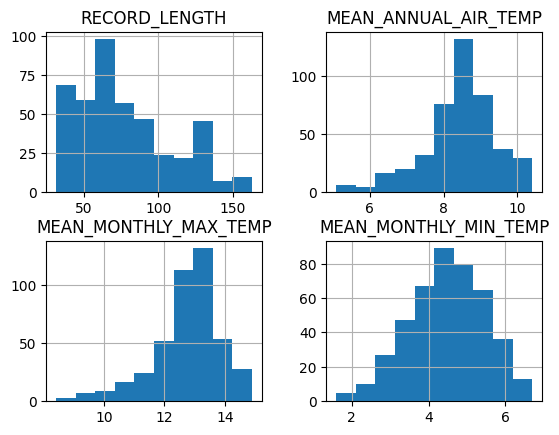

In [ ]:
Xi.hist(['RECORD_LENGTH', 'MEAN_ANNUAL_AIR_TEMP',
       'MEAN_MONTHLY_MAX_TEMP', 'MEAN_MONTHLY_MIN_TEMP'])

# Preparing training set and test set

In [ ]:
X=Xi.drop('MEAN_ANNUAL_RAINFALL', axis=1)
y=Xi['MEAN_ANNUAL_RAINFALL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((351, 14), (88, 14))

In [ ]:
columns=dict(zip(Xi.columns, range(len(Xi))))

# Preprocessing: Data Scaling

In [ ]:
scaler_X_train = StandardScaler()
scaler_y_train = StandardScaler()
scaler_X_test= StandardScaler()
scaler_y_test = StandardScaler()

In [ ]:
X_train = scaler_X_train.fit_transform(pd.DataFrame(data=X_train))
y_train = scaler_y_train.fit_transform(pd.DataFrame(data=y_train))
X_test = scaler_X_test.fit_transform(pd.DataFrame(data=X_test))
y_test = scaler_y_test.fit_transform(pd.DataFrame(data=y_test))

# OLS model

## Backward Selection

In [ ]:
#Secuential forward selection
sfs = SFS(
    LinearRegression(), # LinearRegression as the estimator
    k_features=5,
    forward=True,
    scoring='r2',
    cv=2)
# You can access the results after fitting

In [ ]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=2, estimator=LinearRegression(), k_features=(5, 5),
                          scoring='r2')

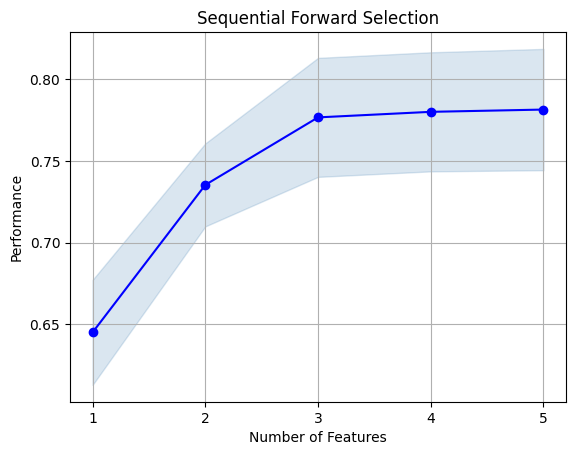

In [ ]:
fig1 = plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [ ]:
sfs.get_metric_dict()

{1: {'feature_idx': (11,),
  'cv_scores': array([0.61300533, 0.67723707]),
  'avg_score': np.float64(0.6451211960990727),
  'feature_names': ('11',),
  'ci_bound': np.float64(0.1381834317008888),
  'std_dev': np.float64(0.03211586906541897),
  'std_err': np.float64(0.03211586906541897)},
 2: {'feature_idx': (1, 11),
  'cv_scores': array([0.70994468, 0.76069785]),
  'avg_score': np.float64(0.73532126465979),
  'feature_names': ('1', '11'),
  'ci_bound': np.float64(0.10918664429309805),
  'std_dev': np.float64(0.025376587689615593),
  'std_err': np.float64(0.025376587689615593)},
 3: {'feature_idx': (1, 10, 11),
  'cv_scores': array([0.74023206, 0.81300653]),
  'avg_score': np.float64(0.7766192974815789),
  'feature_names': ('1', '10', '11'),
  'ci_bound': np.float64(0.1565616296095562),
  'std_dev': np.float64(0.03638723351503498),
  'std_err': np.float64(0.03638723351503498)},
 4: {'feature_idx': (1, 9, 10, 11),
  'cv_scores': array([0.74360443, 0.81642256]),
  'avg_score': np.float64(

##Model

In [ ]:
#selectedVars=list(map(lambda v:columns.get(v),sfs.get_metric_dict()[5]['feature_names']))
selectedVars=np.array(sfs.get_metric_dict()[3]['feature_names']).astype(int)

In [ ]:
X_train_selected=X_train[:,selectedVars]
X_test_selected=X_test[:,selectedVars]

In [ ]:
model_a=sm.OLS(y_train, X_train_selected)
results_a=model_a.fit()
results_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              421.4
Date:                Sun, 17 Aug 2025   Prob (F-statistic):                   1.87e-115
Time:                        02:00:49   Log-Likelihood:                         -228.99
No. Observations:                 351   AIC:                                      464.0
Df Residuals:                     348   BIC:                                      475.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2821      0.025    -11.227      0.000      -0.331      -0.233
x2            -0.2180      0.027     -8.222      0.000      -0.270      -0.166
x3             0.7625      0.027     28.664      0.000       0.710       0.815
==============================================================================
Omnibus:                        6.056   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.281
Skew:                          -0.232   Prob(JB):                       0.0433
Kurtosis:                       3.462   Cond. No.                         1.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



1.   Adjusted R^2 introduce a penalization to R^2 which is the proportion of total variation about the mean Y explained by the regression
2.   F-test: Null hypotesis: variance of SS due to regression and variance of SS about regression are equal.
The model is usefull when MSR is greater than MSE.
3. T-test: Null hypotesis: Coef of an predictor is 0.
The estimator (estimate of thing-test value of thing)/standard error of estimate thing, follows a T distribution.



Variable X2 dont pass the t-tes for 95% of signicance

Text(0.5, 1.0, 'Residual Plot')

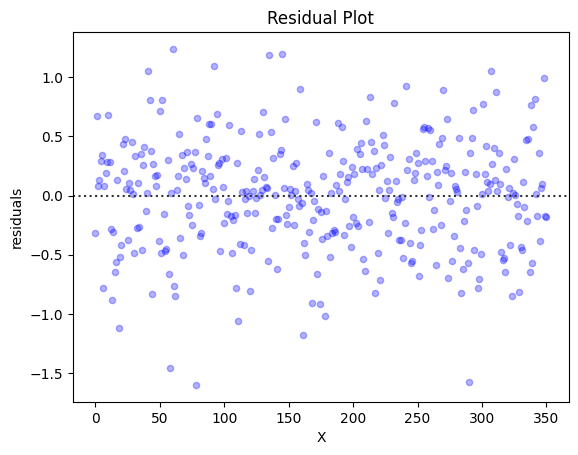

In [ ]:
resid_df = pd.DataFrame({'X': range(len(results_a.resid)), 'residuals': results_a.resid})
sns.residplot(x="X", y="residuals", data=resid_df, scatter_kws={"s": 20, "color":'blue', "alpha":0.3}).set_title('Residual Plot')


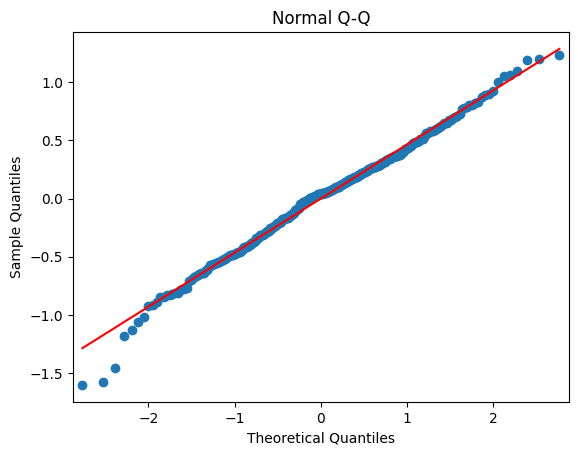

In [ ]:
sm.qqplot(results_a.resid, line='s')
plt.title('Normal Q-Q')
plt.show()

In [ ]:
pred=results_a.predict(X_test_selected)

In [ ]:
pba=pd.DataFrame({'X': range(len(pred)), 'real_value': y_test})

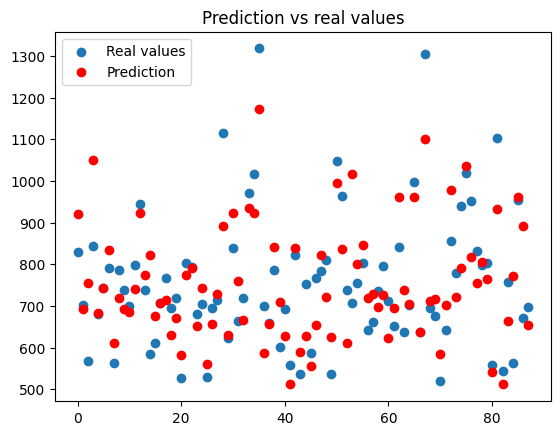

In [ ]:
plt.scatter(range(len(y_test)),scaler_y_test.inverse_transform(y_test))
plt.scatter(range(len(y_test)),scaler_y_test.inverse_transform(pred.reshape(-1,1)), color='red')
plt.title('Prediction vs real values')
plt.legend(['Real values', 'Prediction'])
plt.show()


In [ ]:
def model_rmse(model_results):
    return np.sqrt(model_results.mse_resid)

In [ ]:
def diff_rmse(obs, preds):
    return np.sqrt(np.sum((obs-preds)**2)/len(obs))

In [ ]:
from sklearn.metrics import mean_squared_error
test_rmse=mean_squared_error(y_test, pred)

In [ ]:
model_outcome = {}
model_outcome["OLS_3_predictors"] = {
    "model": model_a,
    "results": results_a,
    "rmse": pd.DataFrame.from_dict({"name": pd.Index(["OLS_3_predictors"]), "train_RMSE": results_a.mse_resid, "test_RMSE": test_rmse})
}

In [ ]:
rmses=pd.DataFrame(model_outcome['OLS_3_predictors']['rmse'])

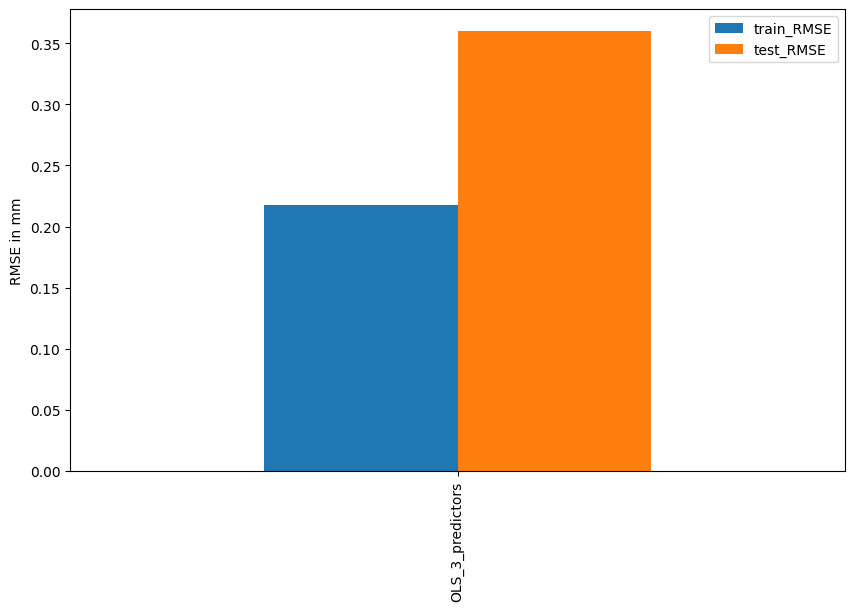

In [ ]:
_, ax = plt.subplots(figsize=(10,6))
rmses.plot(kind="bar", x="name", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE in mm")
plt.show()

Normal distr Test Anderson Darling

Test Levene homocedasti

Durbin watson Correlated errors

In [ ]:
rmses = pd.concat([model_outcome["simple_alt"]["rmse"],model_outcome["simple_meanAnnTemp"]["rmse"],model_outcome["multi_alt_rain"]["rmse"]])

In [ ]:
#rmses = pd.concat([rmses, model_outcome["multi_alt_rain"]["rmse"]])
rmses

,name,train_RMSE,test_RMSE
0,simple alt model,141.840524,143.168566
0,simple meanAnnTemp model,102.166540,125.758328
0,multi alt rain model,101.129135,124.821539


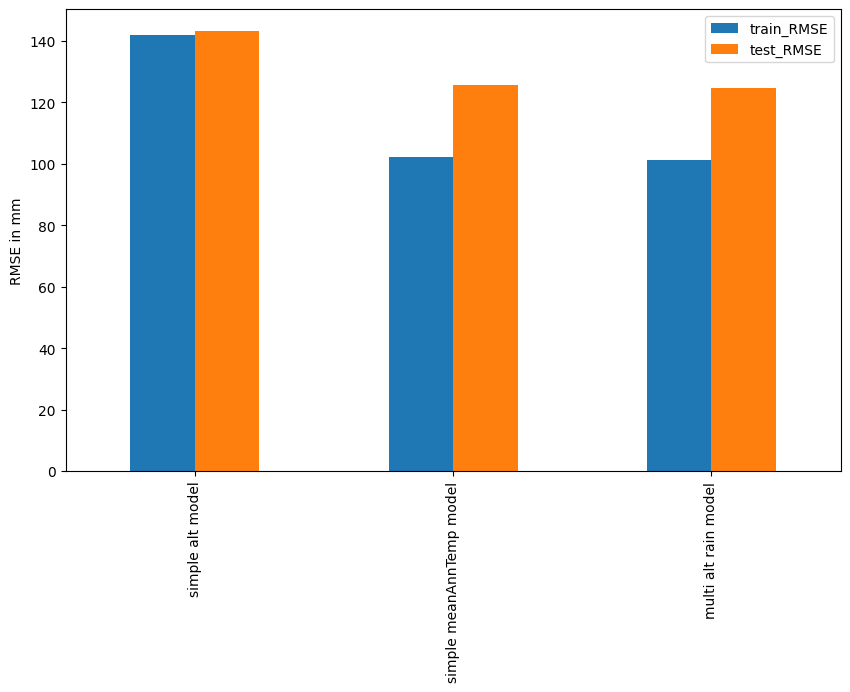

In [ ]:
_, ax = plt.subplots(figsize=(10,6))
rmses.plot(kind="bar", x="name", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE in mm")
plt.show()